<a href="https://colab.research.google.com/github/sayyed-uoft/fullstackai/blob/main/16_Recurrent_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Strata.ai - Artificial Intelligence Certificate 

# Module 3: Practical Deep Learning

# Recurrent Neural Network
**Text Book:** Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow, Second Edition, Aurélien Géron

Source: https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb

# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Recurrent Neural Networks

In this chapter, we are going to discuss **recurrent neural networks (RNN)**, a class of nets that can predict the future (well, up to a point, of course):
- They can analyze **time series data** such as stock prices, and tell you when to buy or sell. 
- In autonomous driving systems, they can anticipate car trajectories and help avoid accidents. 
- More generally, they can work on sequences of arbitrary lengths, rather than on fixed-sized inputs like all the nets we have discussed so far. For example, they can take sentences, documents, or audio samples as input, making them extremely useful for natural language processing (NLP) systems such as automatic translation, speech-to-text, or sentiment analysis (e.g., reading movie reviews and extracting the rater’s feeling about the movie).

## Recurrent Neurons

- A recurrent neural network looks very much like a feed-forward neural network, except it also has connections pointing backward. 
- Let’s look at the simplest possible RNN, composed of just one neuron receiving inputs, producing an output, and sending that output back to itself, as shown in the Figure below:
  - At each time step t (also called a frame), this recurrent neuron receives the inputs $x_{(t)}$ as well as its own output from the previous time step, $y_{(t–1)}$. 
  - We can represent this tiny network against the time axis. This is called unrolling the network through time.

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/rnn.png" width="80%"></img>

Now, to create a layer:
- Every neuron receives both the input vector $x_{(t)}$ and the output vector from the previous time step $y_{(t-1)}$.
- Note that both the inputs and outputs are vectors now.

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/rnn2.png" width="80%"></img>

Each recurrent neuron has two sets of weights:
- for the inputs $x_{(t)}$: $w_x$
- for the outputs of the previous time step $y_{(t-1)}$: $w_y$

## Memory Cells

- Since the output of a recurrent neuron at time step $t$ is a function of all the inputs from previous time steps, you could say it has a form of **memory**.
- A part of a neural network that preserves some state across time steps is called a **memory cell** (or simply a cell).
- A single recurrent neuron, or a layer of recurrent neurons, is a very **basic cell**, but later in this section we will look at some more complex and powerful types of cells.
- In general, a cell’s state $h_{(t)}$ is a function of some inputs $x_{(t)}$ nd its state at the previous time step:

$$h_{(t)} = f(h_{(t-1)}, x_{(t)})$$

- The network's output $y_{(t)}$, is also a function of the previous $y_{(t-1)}$ and $x_{(t)}$.

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/rnn_state.png" width="80%"></img>

## Input and Output Sequences

- An RNN can simultaneously take a sequence of inputs and produce a sequence of outputs: Useful for predicting time series.
- RNNs can also take a sequence of inputs, and ignore all outputs except for the last one: Sequence-to-vector network. i.e. feed the network a sequence of words corresponding to a movie review, and the network would output a sentiment score (e.g., from –1 [negative] to +1 [positive]).
- Single input at the first time step (and zeros for all other time steps), and let it output a sequence: Vector-to-sequence network. i.e. the input could be an image, and the output could be a caption for that image.
- Sequence-to-vector network (encoder), followed by a vector-to-sequence network (decoder): translating a sentence from one language to another. This two-step model, called an Encoder–Decoder. This model works better because the last words of a sentence can affect the first words of the translation.

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/rnn_types.png" width="80%"></img>

# Deep RNNs

Similar to other types of Neural networks, not every problem can be addressed by a simple RNN. It is quite common to stack multiple layers of cells, as shown in the Figure below. This gives you a deep
RNN.

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/deep_rnn.png" width="70%"></img>

If you build a very deep RNN, it may end up overfitting the training set. To prevent that, a common technique is to apply dropout. You can add a dropout layer before or after the RNN as usual, or between the RNN layers.

# The Difficulty of Training over Many Time Steps

- To train an RNN on long sequences, you will need to run it over many time steps, making the unrolled RNN a very deep network. Just like any deep neural network it may suffer from the vanishing/exploding gradients problem and take forever to train. Many of the tricks we discussed to alleviate this problem can be used for deep unrolled RNNs as well: 
  - Good parameter initialization
  - Nonsaturating activation functions (e.g., ReLU) 
  - Batch Normalization
  - Gradient Clipping
  - Faster Optimizers 
  
- However, if the RNN needs to handle even moderately long sequences (e.g., 100 inputs), then training will still be very slow. The simplest and most common solution to this problem is to unroll the RNN only over a limited number of time steps during training. This is called truncated backpropagation through time.

Another problem faced by long-running RNNs is the fact that the memory of the first inputs gradually fades away. Indeed, due to the transformations that the data goes through when traversing an RNN, some information is lost after each time step. After a while, the RNN’s state contains virtually no trace of the first inputs. This can be a showstopper. 

To solve this problem, various types of cells with long-term memory have been introduced. They have proved so successful that the basic cells are not much used anymore. The two most common types are:

- Long Short-Term Memory (LSTM)
- Gated Recurrent Unit (GRU)

## LSTM Cell

- The Long Short-Term Memory (LSTM) cell was proposed in 1973 by Sepp Hochreiter and Jürgen Schmidhuber.

- An LSTM cell will:
  - Converge faster while training
  - Detect long-term dependencies in the data.

- LSTM cells manage two state vectors, and for performance reasons they are kept separate by default. 
- Architecture:



<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/lstm.png" width="70%"></img>

- The key idea is that the network can learn what to store in the long-term state, what to throw away, and what to read from it.
- The LSTM cell looks exactly like a regular cell, except that its state is split in two vectors: 
  - $h_{(t)}$ the short-term state and
  - $c_{(t)}$ as the long-term state.
- As the long-term state $c_{(t)}$ traverses the network:
  - it first goes through a forget gate, dropping some memories
  - adds some new memories via the addition operation.
  - At each time step, some memories are dropped and some memories are added.
- The long-term state is then copied and passed through the tanh function, the result is filtered by the output gate. This produces the short-term state $h_{(t)}$.

- An LSTM cell can learn to recognize an important input, store it in the long-term state, learn to preserve it for as long as it is needed, and learn to extract it whenever it is needed.
- They have been amazingly successful at capturing long-term patterns in time series, long texts, audio recordings, and more.


## GRU Cell

The Gated Recurrent Unit (GRU) cell was proposed by Kyunghyun Cho et al. in a 2014.

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/gru.png" width="70%"></img>

The GRU cell is a simplified version of the LSTM cell, and it seems to perform just as well but faster:

- Both state vectors are merged into a single vector .
- A single gate controller controls both the forget gate and the input gate:
  - If the gate controller outputs a 1, the forget gate is open and the input gate is closed. 
  - If it outputs a 0, the opposite happens.
  - Whenever a memory must be stored, the location is erased first.
- There is no output gate;
- The full state vector is output at every time step.
- There is a new gate controller that controls which part of the previous state will be shown to the main layer.

# Basic RNNs in Keras

### Generate the Dataset

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

Lewt's first assume we are going to predict the value at time 51 from the previous 50 values.

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Let's plot three samples. The true value is marked by a blue cross:

Saving figure time_series_plot


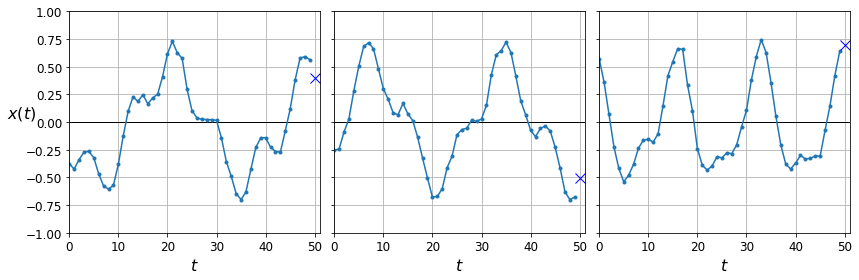

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

### Computing Some Baselines

Naive predictions (just predict the last observed value). Red circle shows the prediction:

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

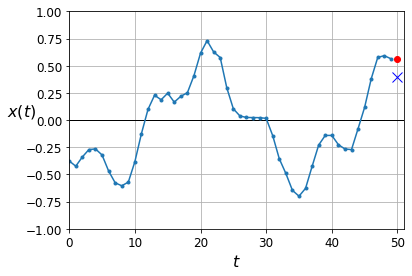

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Linear predictions:

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 2ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0062

In [9]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0042


0.004168086219578981

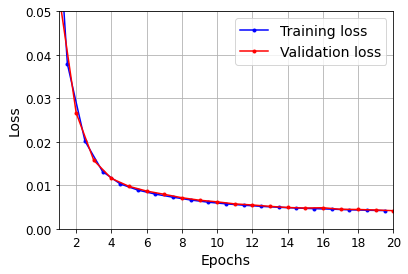

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

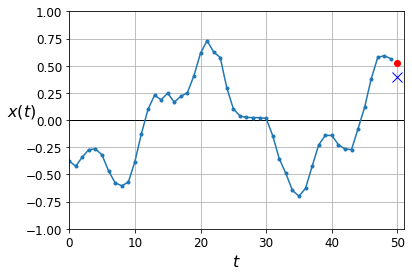

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a Simple RNN

As discussed, Simple RNN is a fully-connected RNN where the output is to be fed back to input.

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0116 - val_lo

In [13]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0109


0.010881561785936356

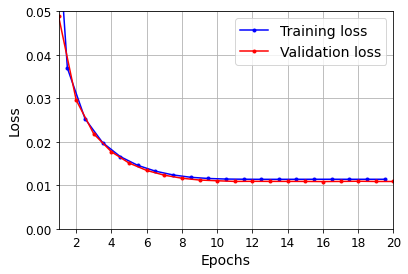

In [14]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

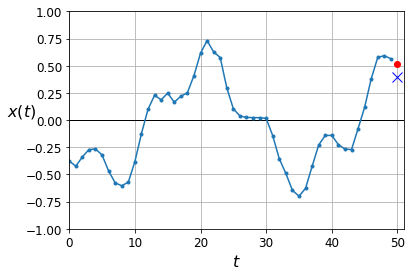

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 24s 105ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 23s 105ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 23s 106ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 23s 105ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 23s 103ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 23s 105ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 24s 107ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 23s 104ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 23s 104ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 23s 105ms/step - l

In [17]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 11ms/step - loss: 0.0029


0.0029105606954544783

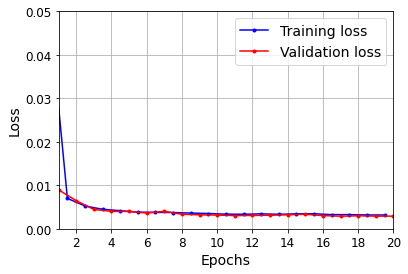

In [18]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

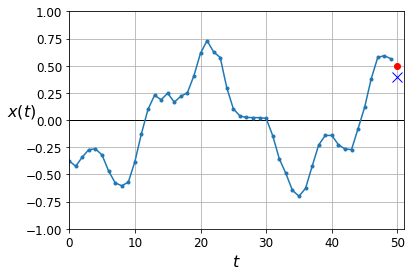

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Make the second `SimpleRNN` layer return only the last output:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 5s 679us/sample - loss: 0.0221 - val_loss: 0.0053
Epoch 2/20
7000/7000 [==============================] - 4s 544us/sample - loss: 0.0043 - val_loss: 0.0037
Epoch 3/20
7000/7000 [==============================] - 4s 547us/sample - loss: 0.0035 - val_loss: 0.0032
Epoch 4/20
7000/7000 [==============================] - 4s 546us/sample - loss: 0.0033 - val_loss: 0.0032
Epoch 5/20
7000/7000 [==============================] - 4s 544us/sample - loss: 0.0032 - val_loss: 0.0030
Epoch 6/20
7000/7000 [==============================] - 4s 543us/sample - loss: 0.0031 - val_loss: 0.0030
Epoch 7/20
7000/7000 [==============================] - 4s 545us/sample - loss: 0.0031 - val_loss: 0.0028
Epoch 8/20
7000/7000 [==============================] - 4s 553us/sample - loss: 0.0031 - val_loss: 0.0028
Epoch 9/20
7000/7000 [==============================] - 4s 552us/sample - loss: 0.0030 - val_loss: 0.002

In [ ]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 116us/sample - loss: 0.0026


0.0025768046267330646

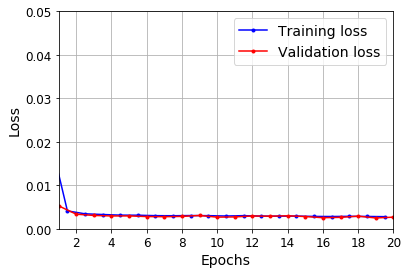

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

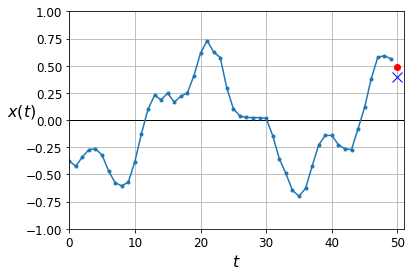

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

In [ ]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [ ]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


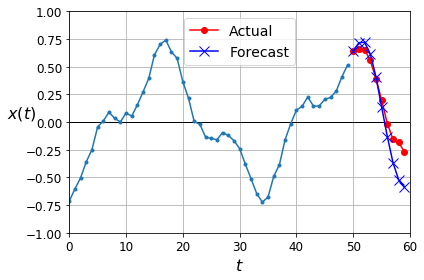

In [ ]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one:

In [ ]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [ ]:
Y_pred.shape

(2000, 10)

In [ ]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.027277283

Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [ ]:
Y_naive_pred = np.tile(X_valid[:, -1], 10) # take the last time step value, and repeat it 10 times
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.25697407

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 0s 54us/sample - loss: 0.1348 - val_loss: 0.0610
Epoch 2/20
7000/7000 [==============================] - 0s 32us/sample - loss: 0.0501 - val_loss: 0.0427
Epoch 3/20
7000/7000 [==============================] - 0s 31us/sample - loss: 0.0388 - val_loss: 0.0356
Epoch 4/20
7000/7000 [==============================] - 0s 32us/sample - loss: 0.0334 - val_loss: 0.0314
Epoch 5/20
7000/7000 [==============================] - 0s 31us/sample - loss: 0.0299 - val_loss: 0.0286
Epoch 6/20
7000/7000 [==============================] - 0s 30us/sample - loss: 0.0275 - val_loss: 0.0264
Epoch 7/20
7000/7000 [==============================] - 0s 31us/sample - loss: 0.0258 - val_loss: 0.0251
Epoch 8/20
7000/7000 [==============================] - 0s 30us/sample - loss: 0.0245 - val_loss: 0.0237
Epoch 9/20
7000/7000 [==============================] - 0s 29us/sample - loss: 0.0235 - val_loss: 0.0229
Epoch 1

Now let's create an RNN that predicts all 10 next values at once:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 5s 692us/sample - loss: 0.0665 - val_loss: 0.0317
Epoch 2/20
7000/7000 [==============================] - 4s 552us/sample - loss: 0.0268 - val_loss: 0.0221
Epoch 3/20
7000/7000 [==============================] - 4s 537us/sample - loss: 0.0188 - val_loss: 0.0166
Epoch 4/20
7000/7000 [==============================] - 4s 532us/sample - loss: 0.0159 - val_loss: 0.0137
Epoch 5/20
7000/7000 [==============================] - 4s 538us/sample - loss: 0.0138 - val_loss: 0.0127
Epoch 6/20
7000/7000 [==============================] - 4s 543us/sample - loss: 0.0132 - val_loss: 0.0117
Epoch 7/20
7000/7000 [==============================] - 4s 551us/sample - loss: 0.0119 - val_loss: 0.0117
Epoch 8/20
7000/7000 [==============================] - 4s 558us/sample - loss: 0.0115 - val_loss: 0.0119
Epoch 9/20
7000/7000 [==============================] - 4s 565us/sample - loss: 0.0110 - val_loss: 0.011

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

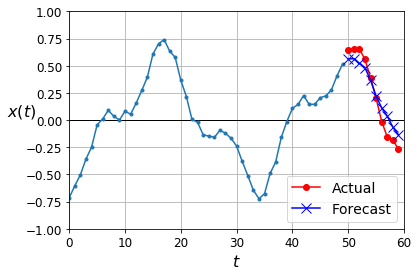

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [ ]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 5s 732us/sample - loss: 0.0498 - last_time_step_mse: 0.0388 - val_loss: 0.0416 - val_last_time_step_mse: 0.0321
Epoch 2/20
7000/7000 [==============================] - 4s 572us/sample - loss: 0.0388 - last_time_step_mse: 0.0281 - val_loss: 0.0332 - val_last_time_step_mse: 0.0223
Epoch 3/20
7000/7000 [==============================] - 4s 575us/sample - loss: 0.0321 - last_time_step_mse: 0.0208 - val_loss: 0.0304 - val_last_time_step_mse: 0.0196
Epoch 4/20
7000/7000 [==============================] - 4s 579us/sample - loss: 0.0294 - last_time_step_mse: 0.0182 - val_loss: 0.0278 - val_last_time_step_mse: 0.0165
Epoch 5/20
7000/7000 [==============================] - 4s 597us/sample - loss: 0.0271 - last_time_step_mse: 0.0153 - val_loss: 0.0262 - val_last_time_step_mse: 0.0141
Epoch 6/20
7000/7000 [==============================] - 4s 573us/sample - loss: 0.0245 - last_time_step_mse: 0.0

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

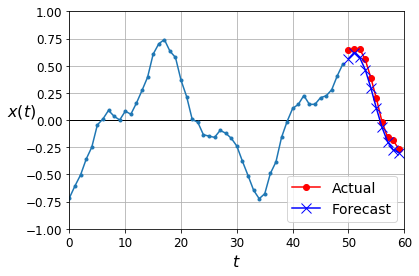

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# LSTMs

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0372
Epoch 2/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0480 - last_time_step_mse: 0.0281 - val_loss: 0.0423 - val_last_time_step_mse: 0.0211
Epoch 3/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0390 - last_time_step_mse: 0.0182 - val_loss: 0.0371 - val_last_time_step_mse: 0.0164
Epoch 4/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0335 - val_last_time_step_mse: 0.0143
Epoch 5/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0325 - last_time_step_mse: 0.0136 - val_loss: 0.0314 - val_last_time_step_mse: 0.0124
Epoch 6/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0308 - last_time_step_mse: 0.0123 - val_l

In [ ]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 0s 234us/sample - loss: 0.0240 - last_time_step_mse: 0.0086


[0.024016654595732687, 0.00855141]

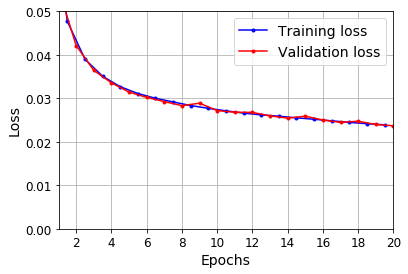

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

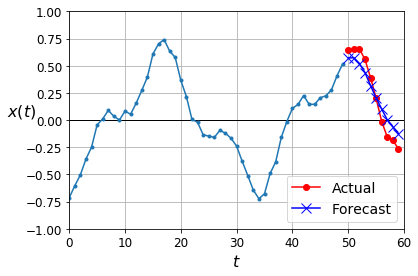

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRUs

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0742 - last_time_step_mse: 0.0663 - val_loss: 0.0523 - val_last_time_step_mse: 0.0421
Epoch 2/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0327
Epoch 3/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0418 - last_time_step_mse: 0.0305 - val_loss: 0.0391 - val_last_time_step_mse: 0.0271
Epoch 4/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0373 - last_time_step_mse: 0.0249 - val_loss: 0.0343 - val_last_time_step_mse: 0.0205
Epoch 5/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0327 - last_time_step_mse: 0.0179 - val_loss: 0.0313 - val_last_time_step_mse: 0.0158
Epoch 6/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0308 - last_time_step_mse: 0.0155 - val_l

In [ ]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 0s 201us/sample - loss: 0.0241 - last_time_step_mse: 0.0103


[0.02407100349664688, 0.010298318]

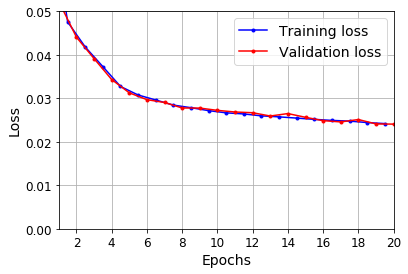

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

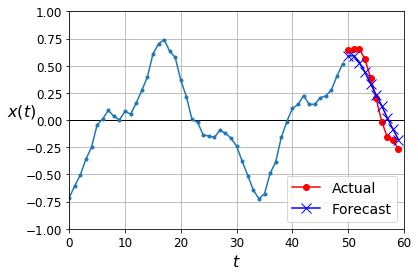

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()